In [2]:
from floppity import Retrieval, helpers
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import torch
# from corner import corner
from tqdm import trange
from floppity.simulators import read_ARCiS_input, ARCiS, mock_simulator

### Create simulator (function that takes parameters and returns spectra)

In [3]:
def gaussian(x, centers, sigmas, amplitudes):
    """Add multiple Gaussian features.

    Args:
        x (np.ndarray): Input x-axis (e.g., wavelengths).
        centers (list): List of Gaussian centers.
        sigmas (list): List of Gaussian standard deviations.
        amplitudes (list): List of Gaussian amplitudes.

    Returns:
        np.ndarray: Sum of all Gaussian features evaluated at x.
    """
    y = np.ones_like(x)
    for c, s, a in zip(centers, sigmas, amplitudes):
        y -= a * np.exp(-0.5 * ((x - c) / (s)) ** 2)
    return y

def simulator(obs, pars, thread=0):
    ndims=pars.shape[1]

    c=pars[:,0:ndims//3]
    s=pars[:,ndims//3:2*ndims//3]
    a=pars[:,2*ndims//3:3*ndims//3]
    
    x = {}
    for key in obs.keys():
        wvl = obs[key][:,0]
        x[key] = np.empty([len(c), len(wvl)])
        for i in trange(len(c)):
            x[key][i]=gaussian(wvl, c[i], s[i], a[i])
    return x

### Create synthetic observation to test

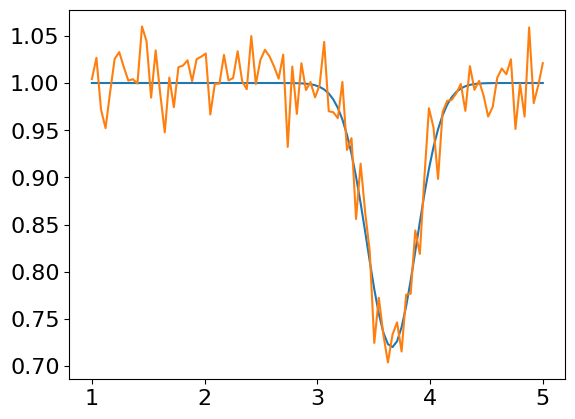

In [ ]:
wvl = np.linspace(1,5,100)
f = gaussian(wvl, [3.66], [0.22], [0.28])
noise=0.03*np.random.standard_normal(len(wvl))
plt.plot(wvl, f)
plt.plot(wvl, f+noise)

synthobs = helpers.create_obs_file(wvl, f+noise, 0.03*np.ones_like(f))

np.savetxt("../src/floppity/data/obs_3.66_0.22_0.28.txt", synthobs)

### Run nested sampling to have as baseline

In [4]:
import dynesty

synthobs = np.loadtxt('../src/floppity/data/obs_3.66_0.22_0.28.txt')

def log_likelihood(x):
    OBS = synthobs
    simulated = gaussian(OBS[:,0],[x[0]], [x[1]], [x[2]])
    residual = OBS[:,1] - simulated
    log_L = -0.5 * np.sum((residual**2 / OBS[:,2]**2) + np.log(2 * np.pi * OBS[:,2]**2))
    return log_L


def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior"""
    x=np.array(u)
    x[0]=1+4*u[0]
    x[1]=0.1+0.6*u[1]
    x[2]=u[2]

    return x

In [5]:
sampler = dynesty.NestedSampler(log_likelihood, ptform, 3, nlive=500)
sampler.run_nested(dlogz=0.1)

8972it [00:07, 1238.34it/s, +500 | bound: 24 | nc: 1 | ncall: 36659 | eff(%): 26.195 | loglstar:   -inf < 290.277 <    inf | logz: 274.692 +/-  0.169 | dlogz:  0.000 >  0.100]


In [6]:
sresults = sampler.results

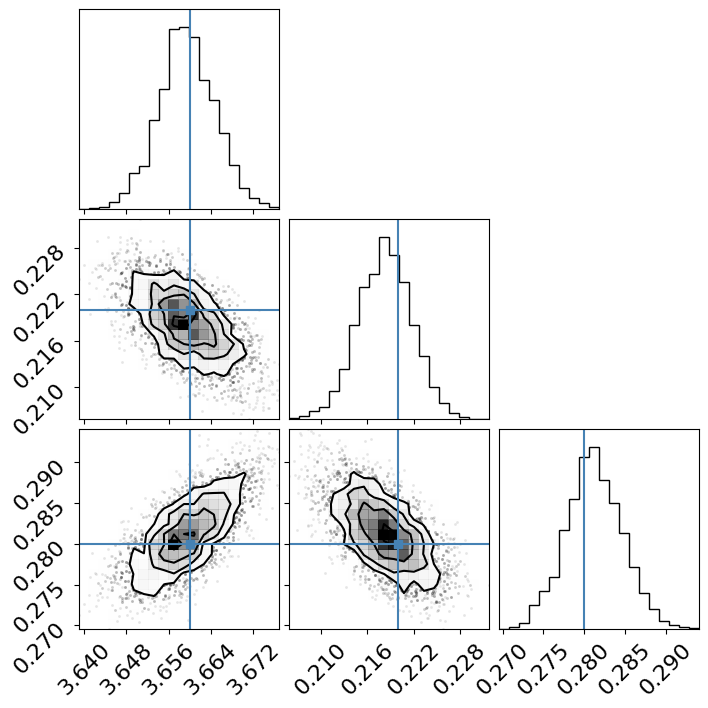

In [7]:
from corner import corner
fig=corner(sresults.samples_equal(),
truths=[3.66, 0.22, 0.28])

## Single retrieval

### Setup retrieval

In [33]:
R = Retrieval(mock_simulator)

### Get observation
R.get_obs(["../src/floppity/data/obs_3.66_0.22_0.28.txt"])

### Add parameters
R.add_parameter('center', 1, 5)
R.add_parameter('sigma', 0.1, 0.7)
R.add_parameter('amplitude', 0, 1)

In [34]:
training_kwargs= dict(
    stop_after_epochs = 10,
    num_atoms = 10,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=3,
    transforms=5,
    blocks=2,
    hidden=32,
    dropout=0.05
)

### Run retrieval

In [35]:
R.run(
    flow_kwargs=flow_kwargs, 
    resume=False, 
    n_threads=1,
    n_aug=1, 
    training_kwargs=training_kwargs, 
    n_rounds=100, 
    n_samples=10
    )

Starting training...
Round 1
 Neural network successfully converged after 27 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: 0.4899
        -------------------------
        
Round 2


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 11 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 11
        Best validation performance: -1.6013
        -------------------------
        
Round 3


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 12 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 12
        Best validation performance: -1.1741
        -------------------------
        
Round 4


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 11 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 11
        Best validation performance: -2.6211
        -------------------------
        
Round 5


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -0.4928
        -------------------------
        
Round 6


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 11 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 11
        Best validation performance: -3.4355
        -------------------------
        
Round 7


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -3.7170
        -------------------------
        
Round 8


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 12 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 12
        Best validation performance: -2.8808
        -------------------------
        
Round 9


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -3.9172
        -------------------------
        
Round 10


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 119 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 119
        Best validation performance: -7.0026
        -------------------------
        
Round 11


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -6.6769
        -------------------------
        
Round 12


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.
        -------------------------
        ||||| ROUND 12 STATS |||||:
        -------------------------
        Epochs trained: 43
        Best validation performance: -5.4699
        -------------------------
        
Round 13


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 13 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -6.9108
        -------------------------
        
Round 14


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.
        -------------------------
        ||||| ROUND 14 STATS |||||:
        -------------------------
        Epochs trained: 54
        Best validation performance: -6.5764
        -------------------------
        
Round 15


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.
        -------------------------
        ||||| ROUND 15 STATS |||||:
        -------------------------
        Epochs trained: 76
        Best validation performance: -8.7456
        -------------------------
        
Round 16


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.
        -------------------------
        ||||| ROUND 16 STATS |||||:
        -------------------------
        Epochs trained: 76
        Best validation performance: -8.5817
        -------------------------
        
Round 17


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 69 epochs.
        -------------------------
        ||||| ROUND 17 STATS |||||:
        -------------------------
        Epochs trained: 69
        Best validation performance: -10.0529
        -------------------------
        
Round 18


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 18 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -9.4916
        -------------------------
        
Round 19


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 88 epochs.
        -------------------------
        ||||| ROUND 19 STATS |||||:
        -------------------------
        Epochs trained: 88
        Best validation performance: -11.3026
        -------------------------
        
Round 20


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.
        -------------------------
        ||||| ROUND 20 STATS |||||:
        -------------------------
        Epochs trained: 43
        Best validation performance: -9.0243
        -------------------------
        
Round 21


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 21 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -9.0052
        -------------------------
        
Round 22


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 22 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -9.5213
        -------------------------
        
Round 23


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 23 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -9.6439
        -------------------------
        
Round 24


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 71 epochs.
        -------------------------
        ||||| ROUND 24 STATS |||||:
        -------------------------
        Epochs trained: 71
        Best validation performance: -10.1692
        -------------------------
        
Round 25


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 25 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: -9.6620
        -------------------------
        
Round 26


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 26 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -10.4875
        -------------------------
        
Round 27


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 65 epochs.
        -------------------------
        ||||| ROUND 27 STATS |||||:
        -------------------------
        Epochs trained: 65
        Best validation performance: -10.4408
        -------------------------
        
Round 28


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 52 epochs.
        -------------------------
        ||||| ROUND 28 STATS |||||:
        -------------------------
        Epochs trained: 52
        Best validation performance: -10.8132
        -------------------------
        
Round 29


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.
        -------------------------
        ||||| ROUND 29 STATS |||||:
        -------------------------
        Epochs trained: 56
        Best validation performance: -11.3822
        -------------------------
        
Round 30


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 30 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -11.3110
        -------------------------
        
Round 31


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.
        -------------------------
        ||||| ROUND 31 STATS |||||:
        -------------------------
        Epochs trained: 47
        Best validation performance: -11.7961
        -------------------------
        
Round 32


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.
        -------------------------
        ||||| ROUND 32 STATS |||||:
        -------------------------
        Epochs trained: 48
        Best validation performance: -11.1422
        -------------------------
        
Round 33


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 33 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: -11.9466
        -------------------------
        
Round 34


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 34 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -11.1977
        -------------------------
        
Round 35


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.
        -------------------------
        ||||| ROUND 35 STATS |||||:
        -------------------------
        Epochs trained: 72
        Best validation performance: -12.2828
        -------------------------
        
Round 36


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 36 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -11.8476
        -------------------------
        
Round 37


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 86 epochs.
        -------------------------
        ||||| ROUND 37 STATS |||||:
        -------------------------
        Epochs trained: 86
        Best validation performance: -12.5436
        -------------------------
        
Round 38


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 85 epochs.
        -------------------------
        ||||| ROUND 38 STATS |||||:
        -------------------------
        Epochs trained: 85
        Best validation performance: -12.0266
        -------------------------
        
Round 39


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.
        -------------------------
        ||||| ROUND 39 STATS |||||:
        -------------------------
        Epochs trained: 55
        Best validation performance: -12.9014
        -------------------------
        
Round 40


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.
        -------------------------
        ||||| ROUND 40 STATS |||||:
        -------------------------
        Epochs trained: 59
        Best validation performance: -13.1291
        -------------------------
        
Round 41


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 41 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: -12.6508
        -------------------------
        
Round 42


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 83 epochs.
        -------------------------
        ||||| ROUND 42 STATS |||||:
        -------------------------
        Epochs trained: 83
        Best validation performance: -12.6821
        -------------------------
        
Round 43


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 43 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -12.4635
        -------------------------
        
Round 44


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 44 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -12.1725
        -------------------------
        
Round 45


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 45 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -13.1108
        -------------------------
        
Round 46


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 46 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -12.9439
        -------------------------
        
Round 47


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 47 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -12.5660
        -------------------------
        
Round 48


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.
        -------------------------
        ||||| ROUND 48 STATS |||||:
        -------------------------
        Epochs trained: 38
        Best validation performance: -13.5654
        -------------------------
        
Round 49


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.
        -------------------------
        ||||| ROUND 49 STATS |||||:
        -------------------------
        Epochs trained: 38
        Best validation performance: -13.1365
        -------------------------
        
Round 50


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 56 epochs.
        -------------------------
        ||||| ROUND 50 STATS |||||:
        -------------------------
        Epochs trained: 56
        Best validation performance: -13.6561
        -------------------------
        
Round 51


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 51 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -13.9149
        -------------------------
        
Round 52


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 52 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -14.4806
        -------------------------
        
Round 53


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.
        -------------------------
        ||||| ROUND 53 STATS |||||:
        -------------------------
        Epochs trained: 47
        Best validation performance: -14.1694
        -------------------------
        
Round 54


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.
        -------------------------
        ||||| ROUND 54 STATS |||||:
        -------------------------
        Epochs trained: 58
        Best validation performance: -14.8028
        -------------------------
        
Round 55


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.
        -------------------------
        ||||| ROUND 55 STATS |||||:
        -------------------------
        Epochs trained: 46
        Best validation performance: -14.3961
        -------------------------
        
Round 56


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 56 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -14.5649
        -------------------------
        
Round 57


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.
        -------------------------
        ||||| ROUND 57 STATS |||||:
        -------------------------
        Epochs trained: 43
        Best validation performance: -14.5780
        -------------------------
        
Round 58


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.
        -------------------------
        ||||| ROUND 58 STATS |||||:
        -------------------------
        Epochs trained: 47
        Best validation performance: -14.9084
        -------------------------
        
Round 59


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.
        -------------------------
        ||||| ROUND 59 STATS |||||:
        -------------------------
        Epochs trained: 44
        Best validation performance: -14.5280
        -------------------------
        
Round 60


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 60 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -14.6643
        -------------------------
        
Round 61


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 61 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -13.6168
        -------------------------
        
Round 62


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.
        -------------------------
        ||||| ROUND 62 STATS |||||:
        -------------------------
        Epochs trained: 48
        Best validation performance: -14.7399
        -------------------------
        
Round 63


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.
        -------------------------
        ||||| ROUND 63 STATS |||||:
        -------------------------
        Epochs trained: 60
        Best validation performance: -15.3079
        -------------------------
        
Round 64


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.
        -------------------------
        ||||| ROUND 64 STATS |||||:
        -------------------------
        Epochs trained: 43
        Best validation performance: -14.1894
        -------------------------
        
Round 65


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 78 epochs.
        -------------------------
        ||||| ROUND 65 STATS |||||:
        -------------------------
        Epochs trained: 78
        Best validation performance: -15.3219
        -------------------------
        
Round 66


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 66 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -15.1707
        -------------------------
        
Round 67


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 67 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: -15.7009
        -------------------------
        
Round 68


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.
        -------------------------
        ||||| ROUND 68 STATS |||||:
        -------------------------
        Epochs trained: 40
        Best validation performance: -14.8154
        -------------------------
        
Round 69


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 69 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -14.3250
        -------------------------
        
Round 70


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.
        -------------------------
        ||||| ROUND 70 STATS |||||:
        -------------------------
        Epochs trained: 49
        Best validation performance: -14.7407
        -------------------------
        
Round 71


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.
        -------------------------
        ||||| ROUND 71 STATS |||||:
        -------------------------
        Epochs trained: 63
        Best validation performance: -15.1630
        -------------------------
        
Round 72


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 72 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -14.9119
        -------------------------
        
Round 73


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.
        -------------------------
        ||||| ROUND 73 STATS |||||:
        -------------------------
        Epochs trained: 47
        Best validation performance: -15.2677
        -------------------------
        
Round 74


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.
        -------------------------
        ||||| ROUND 74 STATS |||||:
        -------------------------
        Epochs trained: 43
        Best validation performance: -15.5907
        -------------------------
        
Round 75


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 75 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -15.0283
        -------------------------
        
Round 76


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 76 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -15.7806
        -------------------------
        
Round 77


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.
        -------------------------
        ||||| ROUND 77 STATS |||||:
        -------------------------
        Epochs trained: 40
        Best validation performance: -16.1161
        -------------------------
        
Round 78


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 60 epochs.
        -------------------------
        ||||| ROUND 78 STATS |||||:
        -------------------------
        Epochs trained: 60
        Best validation performance: -16.0536
        -------------------------
        
Round 79


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.
        -------------------------
        ||||| ROUND 79 STATS |||||:
        -------------------------
        Epochs trained: 48
        Best validation performance: -15.8233
        -------------------------
        
Round 80


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 80 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -15.5427
        -------------------------
        
Round 81


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 47 epochs.
        -------------------------
        ||||| ROUND 81 STATS |||||:
        -------------------------
        Epochs trained: 47
        Best validation performance: -16.0123
        -------------------------
        
Round 82


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.
        -------------------------
        ||||| ROUND 82 STATS |||||:
        -------------------------
        Epochs trained: 34
        Best validation performance: -15.0639
        -------------------------
        
Round 83


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 83 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -15.2922
        -------------------------
        
Round 84


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 84 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -14.1555
        -------------------------
        
Round 85


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.
        -------------------------
        ||||| ROUND 85 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: -15.2632
        -------------------------
        
Round 86


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.
        -------------------------
        ||||| ROUND 86 STATS |||||:
        -------------------------
        Epochs trained: 36
        Best validation performance: -15.3205
        -------------------------
        
Round 87


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.
        -------------------------
        ||||| ROUND 87 STATS |||||:
        -------------------------
        Epochs trained: 36
        Best validation performance: -15.5286
        -------------------------
        
Round 88


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 88 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -15.8683
        -------------------------
        
Round 89


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 89 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -15.8716
        -------------------------
        
Round 90


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 90 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -15.6028
        -------------------------
        
Round 91


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.
        -------------------------
        ||||| ROUND 91 STATS |||||:
        -------------------------
        Epochs trained: 42
        Best validation performance: -16.2246
        -------------------------
        
Round 92


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 92 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -16.2974
        -------------------------
        
Round 93


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 93 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -15.9640
        -------------------------
        
Round 94


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.
        -------------------------
        ||||| ROUND 94 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: -15.3520
        -------------------------
        
Round 95


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 95 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -15.5454
        -------------------------
        
Round 96


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 96 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -15.7719
        -------------------------
        
Round 97


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 97 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -15.9050
        -------------------------
        
Round 98


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 98 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -15.5739
        -------------------------
        
Round 99


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.
        -------------------------
        ||||| ROUND 99 STATS |||||:
        -------------------------
        Epochs trained: 34
        Best validation performance: -15.7317
        -------------------------
        
Round 100


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.
        -------------------------
        ||||| ROUND 100 STATS |||||:
        -------------------------
        Epochs trained: 45
        Best validation performance: -15.9752
        -------------------------
        


### Save retrieval object

In [27]:
R.save('/Users/floppityflappity/Work/R_1405.pkl')

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/cloudpickle/cloudpickle.py:1303: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  return super().dump(obj)


### Load retrieval object

In [4]:
R=Retrieval.load('r.pkl')

### Resume training

In [192]:
R.run(flow_kwargs=flow_kwargs, resume=True, n_threads=1, training_kwargs=training_kwargs, n_rounds=1, n_samples=1000)

Resuming training...
Round 1


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 94 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 94
        Best validation performance: -15.8227
        -------------------------
        


### Plot loss evolution

Text(0, 0.5, 'Loss')

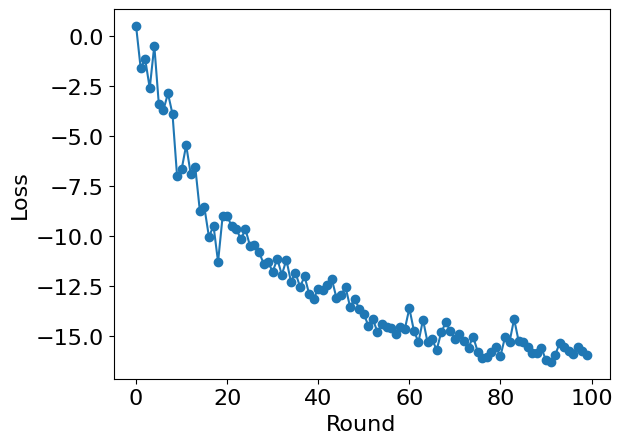

In [36]:
plt.plot(R.inference._summary['best_validation_loss'], marker='o', label=f'{len(R.proposals)}x{R.n_samples}')
plt.xlabel('Round')
plt.ylabel('Loss')

### Plot posterior

#### Aggregate

In [265]:
samples0 = R.proposals[-1].sample((104325//5,))
samples1 = R1.proposals[-1].sample((104325//5,))
samples2 = R2.proposals[-1].sample((104325//5,))
samples3 = R3.proposals[-1].sample((104325//5,))
samples4 = R4.proposals[-1].sample((104325//5,))

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

Drawing 20865 posterior samples:   0%|          | 0/20865 [00:00<?, ?it/s]

In [271]:
agg_samples = helpers.convert_cube(np.vstack((samples0, samples1, samples2, samples3, samples4)), R.parameters)

#### MC draws

In [37]:
draws = []

In [38]:
f = np.concatenate(list(R.obs.values()), 
                axis=0)[:,1].reshape(-1,)
n = np.concatenate(list(R.obs.values()), 
                axis=0)[:,2].reshape(-1,)


In [39]:
n_mc=1000
samples_per_mc=2
for i in range(n_mc):
    default_obs = f+n*np.random.standard_normal(len(n))
    post =R.inference.build_posterior(
            R.posterior_estimator).set_default_x(default_obs)
    draws.append(helpers.convert_cube(post.sample((samples_per_mc,), show_progress_bars=False), R.parameters))


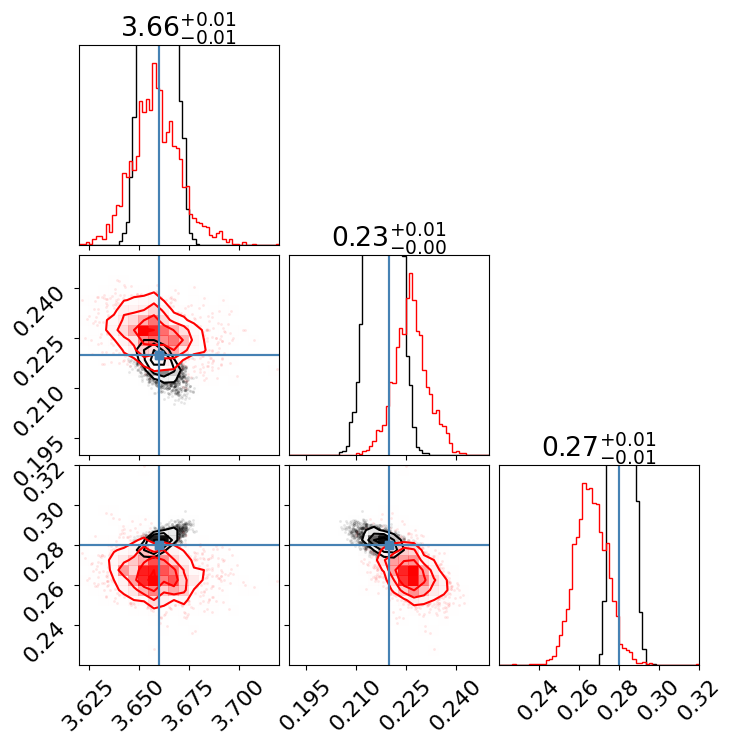

In [42]:
#plot nested sampling posterior
samples = sresults.samples_equal()
narrow=[(3.62,3.72),(0.19,0.25),(0.22,0.32)]
broad=[(1.,5),(0.1,0.7),(0.,1)]
CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    color='k'
)
ns = corner(sresults.samples_equal(), **CORNER_KWARGS)

CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    fig=ns,
    color='red'
)
# fig=R.plot_corner(-1,n_samples=len(samples),**CORNER_KWARGS)
# figure = corner(agg_samples, **CORNER_KWARGS)
fig = corner(np.vstack(draws), **CORNER_KWARGS)

### Posterior predictive check

100%|██████████| 100/100 [00:00<00:00, 3383.76it/s]


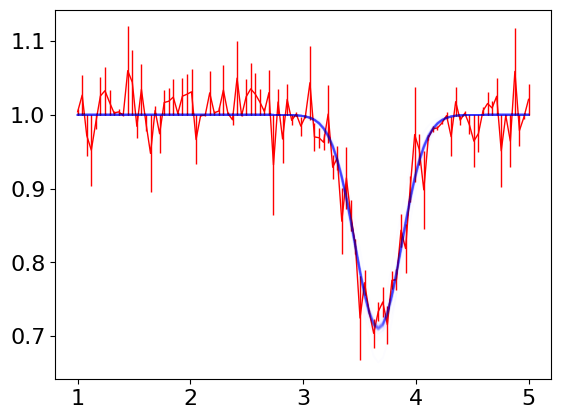

In [41]:
xs = R.post_x
# Xs=np.concatenate(list(xs.values()), axis=1)

# plt.figure(figsize=)
for key in R.obs.keys():
    plt.errorbar(x=R.obs[key][:,0], y=R.obs[key][:,1], yerr=abs(R.obs[key][:,2]), c='r', lw=1, zorder=0)
for i in trange(len(xs[0])):
    for key in R.obs.keys():
        plt.plot(R.obs[key][:,0], xs[key][i], c='b', alpha=0.01, zorder=1)
# plt.xlim(1.5,3.5)
# plt.ylim(0.5,1.05)

In [299]:
from floppity import plot_utils
plot_utils.plot_moment_evolution(R.proposals[:], 5, helpers.compute_moments, R=R, num_repeats=3, sample_size=1000)

TypeError: compute_moments() takes 1 positional argument but 3 were given

## Ensemble retrieval

In [48]:
R = {}
post_draws=[]

n_ens = 10

training_kwargs= dict(
    stop_after_epochs = 10,
    num_atoms = 10,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=3,
    transforms=5,
    blocks=2,
    hidden=32,
    dropout=0.15
)

In [ ]:
for i in range(n_ens):
    R[i] = Retrieval(mock_simulator)

    ### Get observation
    R[i].get_obs(["../src/floppity/data/obs_3.66_0.22_0.28.txt"])

    ### Add parameters
    R[i].add_parameter('center', 1, 5)
    R[i].add_parameter('sigma', 0.1, 0.7)
    R[i].add_parameter('amplitude', 0, 1)

    R[i].run(
        flow_kwargs=flow_kwargs, 
        resume=False, 
        n_threads=1,
        n_aug=1, 
        training_kwargs=training_kwargs, 
        n_rounds=50, 
        n_samples=10
        )

    post_draws.append(helpers.convert_cube(R[i].proposals[-1].sample((1000,)), R[i].parameters))
post_equal_weights = np.vstack(post_draws)

Starting training...
Round 1
 Neural network successfully converged after 42 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 42
        Best validation performance: -0.0340
        -------------------------
        
Round 2


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 13 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 13
        Best validation performance: 0.2602
        -------------------------
        
Round 3


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 77 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 77
        Best validation performance: -3.4046
        -------------------------
        
Round 4


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -3.1199
        -------------------------
        
Round 5


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -3.8199
        -------------------------
        
Round 6


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -4.9893
        -------------------------
        
Round 7


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -4.9229
        -------------------------
        
Round 8


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -5.5047
        -------------------------
        
Round 9


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -5.6920
        -------------------------
        
Round 10


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -5.4334
        -------------------------
        
Round 11


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -6.2408
        -------------------------
        
Round 12


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 12 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -7.6391
        -------------------------
        
Round 13


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 13 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -7.7913
        -------------------------
        
Round 14


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 14 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -7.3638
        -------------------------
        
Round 15


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.
        -------------------------
        ||||| ROUND 15 STATS |||||:
        -------------------------
        Epochs trained: 42
        Best validation performance: -7.0196
        -------------------------
        
Round 16


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 16 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -8.5592
        -------------------------
        
Round 17


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.
        -------------------------
        ||||| ROUND 17 STATS |||||:
        -------------------------
        Epochs trained: 46
        Best validation performance: -9.1265
        -------------------------
        
Round 18


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.
        -------------------------
        ||||| ROUND 18 STATS |||||:
        -------------------------
        Epochs trained: 49
        Best validation performance: -7.4904
        -------------------------
        
Round 19


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 69 epochs.
        -------------------------
        ||||| ROUND 19 STATS |||||:
        -------------------------
        Epochs trained: 69
        Best validation performance: -10.0846
        -------------------------
        
Round 20


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 20 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: -9.2344
        -------------------------
        
Round 21


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.
        -------------------------
        ||||| ROUND 21 STATS |||||:
        -------------------------
        Epochs trained: 34
        Best validation performance: -8.3287
        -------------------------
        
Round 22


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 22 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -10.2330
        -------------------------
        
Round 23


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 23 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -9.0728
        -------------------------
        
Round 24


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.
        -------------------------
        ||||| ROUND 24 STATS |||||:
        -------------------------
        Epochs trained: 41
        Best validation performance: -9.3322
        -------------------------
        
Round 25


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 25 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: -10.9028
        -------------------------
        
Round 26


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.
        -------------------------
        ||||| ROUND 26 STATS |||||:
        -------------------------
        Epochs trained: 63
        Best validation performance: -10.1951
        -------------------------
        
Round 27


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 27 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -9.5868
        -------------------------
        
Round 28


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 28 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -10.4241
        -------------------------
        
Round 29


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 29 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -10.1589
        -------------------------
        
Round 30


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 116 epochs.
        -------------------------
        ||||| ROUND 30 STATS |||||:
        -------------------------
        Epochs trained: 116
        Best validation performance: -11.1041
        -------------------------
        
Round 31


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 31 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -10.1911
        -------------------------
        
Round 32


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 32 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -10.5367
        -------------------------
        
Round 33


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 33 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -11.2523
        -------------------------
        
Round 34


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 78 epochs.
        -------------------------
        ||||| ROUND 34 STATS |||||:
        -------------------------
        Epochs trained: 78
        Best validation performance: -10.2583
        -------------------------
        
Round 35


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 35 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -10.1276
        -------------------------
        
Round 36


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
        -------------------------
        ||||| ROUND 36 STATS |||||:
        -------------------------
        Epochs trained: 21
        Best validation performance: -10.1395
        -------------------------
        
Round 37


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 37 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -9.6283
        -------------------------
        
Round 38


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 38 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -10.3382
        -------------------------
        
Round 39


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
        -------------------------
        ||||| ROUND 39 STATS |||||:
        -------------------------
        Epochs trained: 50
        Best validation performance: -10.7299
        -------------------------
        
Round 40


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 40 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -9.3723
        -------------------------
        
Round 41


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
        -------------------------
        ||||| ROUND 41 STATS |||||:
        -------------------------
        Epochs trained: 21
        Best validation performance: -8.7798
        -------------------------
        
Round 42


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 67 epochs.
        -------------------------
        ||||| ROUND 42 STATS |||||:
        -------------------------
        Epochs trained: 67
        Best validation performance: -11.5887
        -------------------------
        
Round 43


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 43 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -9.7155
        -------------------------
        
Round 44


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 44 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: -10.9677
        -------------------------
        
Round 45


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 12 epochs.
        -------------------------
        ||||| ROUND 45 STATS |||||:
        -------------------------
        Epochs trained: 12
        Best validation performance: -11.5450
        -------------------------
        
Round 46


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.
        -------------------------
        ||||| ROUND 46 STATS |||||:
        -------------------------
        Epochs trained: 38
        Best validation performance: -11.3096
        -------------------------
        
Round 47


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.
        -------------------------
        ||||| ROUND 47 STATS |||||:
        -------------------------
        Epochs trained: 54
        Best validation performance: -11.5073
        -------------------------
        
Round 48


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.
        -------------------------
        ||||| ROUND 48 STATS |||||:
        -------------------------
        Epochs trained: 62
        Best validation performance: -11.2972
        -------------------------
        
Round 49


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 48 epochs.
        -------------------------
        ||||| ROUND 49 STATS |||||:
        -------------------------
        Epochs trained: 48
        Best validation performance: -12.4685
        -------------------------
        
Round 50


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.
        -------------------------
        ||||| ROUND 50 STATS |||||:
        -------------------------
        Epochs trained: 42
        Best validation performance: -12.1205
        -------------------------
        


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Starting training...
Round 1
 Neural network successfully converged after 11 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 11
        Best validation performance: -1.8041
        -------------------------
        
Round 2


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 116 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 116
        Best validation performance: -3.9626
        -------------------------
        
Round 3


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -3.6396
        -------------------------
        
Round 4


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -4.7355
        -------------------------
        
Round 5


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -4.6421
        -------------------------
        
Round 6


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -3.9891
        -------------------------
        
Round 7


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -3.7156
        -------------------------
        
Round 8


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -4.7055
        -------------------------
        
Round 9


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -5.0883
        -------------------------
        
Round 10


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -4.5108
        -------------------------
        
Round 11


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -6.3959
        -------------------------
        
Round 12


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 12 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -5.7143
        -------------------------
        
Round 13


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 13 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -4.7176
        -------------------------
        
Round 14


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 14 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -5.7064
        -------------------------
        
Round 15


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 15 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -5.8035
        -------------------------
        
Round 16


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 78 epochs.
        -------------------------
        ||||| ROUND 16 STATS |||||:
        -------------------------
        Epochs trained: 78
        Best validation performance: -5.5769
        -------------------------
        
Round 17


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 17 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -6.9535
        -------------------------
        
Round 18


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 63 epochs.
        -------------------------
        ||||| ROUND 18 STATS |||||:
        -------------------------
        Epochs trained: 63
        Best validation performance: -8.3070
        -------------------------
        
Round 19


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 19 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -7.8175
        -------------------------
        
Round 20


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.
        -------------------------
        ||||| ROUND 20 STATS |||||:
        -------------------------
        Epochs trained: 38
        Best validation performance: -8.1254
        -------------------------
        
Round 21


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 21 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -7.8400
        -------------------------
        
Round 22


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 61 epochs.
        -------------------------
        ||||| ROUND 22 STATS |||||:
        -------------------------
        Epochs trained: 61
        Best validation performance: -8.3350
        -------------------------
        
Round 23


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.
        -------------------------
        ||||| ROUND 23 STATS |||||:
        -------------------------
        Epochs trained: 34
        Best validation performance: -8.3237
        -------------------------
        
Round 24


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.
        -------------------------
        ||||| ROUND 24 STATS |||||:
        -------------------------
        Epochs trained: 59
        Best validation performance: -8.2643
        -------------------------
        
Round 25


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.
        -------------------------
        ||||| ROUND 25 STATS |||||:
        -------------------------
        Epochs trained: 54
        Best validation performance: -8.2692
        -------------------------
        
Round 26


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 26 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -8.3247
        -------------------------
        
Round 27


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 27 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -9.3138
        -------------------------
        
Round 28


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 28 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -8.4170
        -------------------------
        
Round 29


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 29 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -8.9082
        -------------------------
        
Round 30


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 57 epochs.
        -------------------------
        ||||| ROUND 30 STATS |||||:
        -------------------------
        Epochs trained: 57
        Best validation performance: -9.5448
        -------------------------
        
Round 31


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 31 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -9.2684
        -------------------------
        
Round 32


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 32 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -9.0079
        -------------------------
        
Round 33


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 29

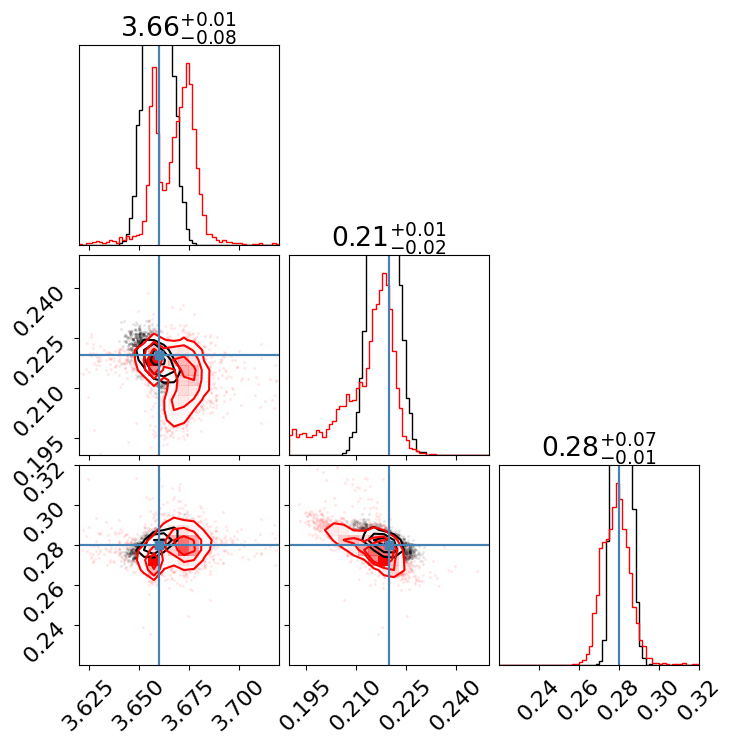

In [47]:
#plot nested sampling posterior
samples = sresults.samples_equal()
narrow=[(3.62,3.72),(0.19,0.25),(0.22,0.32)]
broad=[(1.,5),(0.1,0.7),(0.,1)]
CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    color='k'
)
ns = corner(sresults.samples_equal(), **CORNER_KWARGS)

CORNER_KWARGS=dict(
    plot_density=True,
    hist_bin_factor=3,
    plot_contours=True,
    show_titles=True,
    truths=[3.66, 0.22, 0.28],
    range=narrow,
    fig=ns,
    color='red'
)
# fig=R.plot_corner(-1,n_samples=len(samples),**CORNER_KWARGS)
# figure = corner(agg_samples, **CORNER_KWARGS)
fig = corner(post_equal_weights, **CORNER_KWARGS)